# Usando funções

### Função que realiza busca na internet

In [1]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()

In [2]:
from langchain.agents import Tool

tool_search = Tool(
    name="search tool",
    func=serper.run,
    description="Útil para buscar coisas na internet de forma online"
)

### Função que manda mensagem no telegram

In [3]:
import requests
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())

chat_id = os.getenv("TELEGRAM_CHAT_ID")
token = os.getenv("TELEGRAM_TOKEN")

def send_message(msg):
    """
    Função que manda mensagem para o telegram

    ----------
    parameters
    ----------

    msg: str
        - parâmetro contendo a mensagem que será enviada
    """
    data = {"chat_id": chat_id, "text": msg}
    url = "https://api.telegram.org/bot{}/sendMessage".format(token)
    requests.post(url, data)

In [4]:
tool_notification = Tool(
    name="tool que notifica via telegram",
    func=send_message,
    description="Função que manda mensagem para o telegram quando for pedido."
)

In [5]:
tools = [tool_search, tool_notification]

# Criando grafo

In [6]:
# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

# langchain
from langchain_groq import ChatGroq

# typing
from typing import TypedDict, Annotated

# others
import gradio as gr
from IPython.display import Image, display

/home/rmede/projects/agents-course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Criando o estado

In [7]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Iniciando o construtor de grafo

In [8]:
graph_builder = StateGraph(State)

# Criando nó

In [9]:
llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0,
    max_tokens=300
)

llm_with_tools = llm.bind_tools(tools)

In [10]:
def chatbot_node(old_state: State) -> State:
    # Como estamos usando o typed dict ao invés de BaseModel
    response = llm_with_tools.invoke(old_state["messages"])
    return {"messages": [response]}

graph_builder.add_node("chatbot_node", chatbot_node)
graph_builder.add_node("tools_node", ToolNode(tools=tools))

# Criando edges

In [11]:
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
    {"tools": "tools_node", "__end__": "__end__"}
)

graph_builder.add_edge("tools_node", "chatbot_node")
graph_builder.add_edge(START, "chatbot_node")


# Compilando o grafo

In [12]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

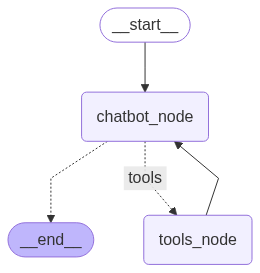

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Rodando tudo

In [ ]:
config = {
    "configurable": {
        "thread_id": "029qry8fshdn932"
    }
}

# Criando função apenas para rodar no gradio

def chat(user_input: str, history):
    result = graph.invoke(
        {
            "messages": [
                {
                    "role": "user",
                    "content": user_input
                }
            ]
        },
        config=config
    )

    print(result)
    return result["messages"][-1].content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Olá, meu nome é ramon', additional_kwargs={}, response_metadata={}, id='18c65139-71ed-418e-b2ef-0ad4a4b2596b'), AIMessage(content='Olá Ramon! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 743, 'total_tokens': 754, 'completion_time': 0.027418976, 'prompt_time': 0.024558455, 'queue_time': 0.268811471, 'total_time': 0.051977431}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6a28c645-6ce4-416d-9b63-4c986d17e046-0', usage_metadata={'input_tokens': 743, 'output_tokens': 11, 'total_tokens': 754})]}
{'messages': [HumanMessage(content='Olá, meu nome é ramon', additional_kwargs={}, response_metadata={}, id='18c65139-71ed-418e-b2ef-0ad4a4b2596b'), AIMessage(content='Olá Ramon! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata

### Verificando os estados

In [15]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Olá, meu nome é ramon', additional_kwargs={}, response_metadata={}, id='18c65139-71ed-418e-b2ef-0ad4a4b2596b'), AIMessage(content='Olá Ramon! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 743, 'total_tokens': 754, 'completion_time': 0.027418976, 'prompt_time': 0.024558455, 'queue_time': 0.268811471, 'total_time': 0.051977431}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6a28c645-6ce4-416d-9b63-4c986d17e046-0', usage_metadata={'input_tokens': 743, 'output_tokens': 11, 'total_tokens': 754}), HumanMessage(content='Me mande no telegram a informação de cotação do real para a libras, por vafor', additional_kwargs={}, response_metadata={}, id='3328fef8-b90a-4b90-aab0-04c1fae56c71'), AIMessage(content='', additional_kwarg

### Verificando os passos da conversa

In [17]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Olá, meu nome é ramon', additional_kwargs={}, response_metadata={}, id='18c65139-71ed-418e-b2ef-0ad4a4b2596b'), AIMessage(content='Olá Ramon! Como posso ajudar você hoje?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 743, 'total_tokens': 754, 'completion_time': 0.027418976, 'prompt_time': 0.024558455, 'queue_time': 0.268811471, 'total_time': 0.051977431}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_42ae451038', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6a28c645-6ce4-416d-9b63-4c986d17e046-0', usage_metadata={'input_tokens': 743, 'output_tokens': 11, 'total_tokens': 754}), HumanMessage(content='Me mande no telegram a informação de cotação do real para a libras, por vafor', additional_kwargs={}, response_metadata={}, id='3328fef8-b90a-4b90-aab0-04c1fae56c71'), AIMessage(content='', additional_kwar